TODO:
- [x] threshold of [-1000,1000]  to make normalizing robust - and test on new data
- [ ] visualize FN and FP and attach number of clicks for these misclassifications
- [x] Compare with uniform distribution (because UD can better detect certain FN, like the plot with clicks all on one pixel) 
- [ ] maybe combine both with a certain weight to get a new representative bad heatmap
- [ ] bad data (H_0 banner is bad) vs uniform distribution (H_1 data is non-bad)


final output
- [ ] visualize FN and FP and attach number of clicks for these misclassifications

Functions: 
```{python}
all_preds = generate_all_preds(outputs, min, max)
plot_heatmaps(heatmap_list)
plot_roc_curve(all_labels, all_preds)
all_f1, best_f1, best_thresh = calculate_all_f1(all_labels, all_preds)
all_outputs = combine_all_outputs(output_list)
fn, fp = identify_misclassified_banners(domains, preds, labels, thresh)
```

# 1. Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

In [2]:
data_heatmap = pd.read_csv('../datasets/A_data_heatmap_300x250_3p.csv')
data_metrics = pd.read_csv('../datasets/A_data_domain_perf_metrics_300x250_3p.csv')
data_heatmap_new1 = pd.read_csv('../datasets/A_data_heatmap_300x250_6p_h2m.csv')
data_heatmap_new2 = pd.read_csv('../datasets/A_data_heatmap_300x250_6p_t2m.csv')

In [3]:
data_metrics_6p = pd.read_csv('../datasets/A_data_domain_perf_metrics_300x250_6p.csv')

In [4]:
data_heatmap_6p = pd.concat([data_heatmap_new1,data_heatmap_new2],axis=0).drop(columns=['click_x_rel','click_y_rel'])

In [5]:
# importing broken banners
cb_333519 = ['ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
       'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
       'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
       'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
       'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
       'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
       'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
       'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
       'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
       'ID_962', 'ID_986']

cb_333346 = ['ID_1247', 'ID_162', 'ID_2534', 'ID_2742', 'ID_526', 'ID_2201',
       'ID_1165', 'ID_743', 'ID_199', 'ID_2145', 'ID_2569', 'ID_643',
       'ID_1305', 'ID_3180', 'ID_3158', 'ID_136', 'ID_293', 'ID_1753',
       'ID_1849', 'ID_2226', 'ID_1462', 'ID_626', 'ID_2863', 'ID_3243',
       'ID_3250', 'ID_1708', 'ID_1238', 'ID_580', 'ID_84', 'ID_2568',
       'ID_2340', 'ID_1803', 'ID_3470', 'ID_139', 'ID_2619', 'ID_2908',
       'ID_1281', 'ID_3308', 'ID_2883', 'ID_1320', 'ID_1333', 'ID_1062',
       'ID_149', 'ID_260', 'ID_599', 'ID_1513', 'ID_3402', 'ID_1888',
       'ID_2972', 'ID_398', 'ID_2339', 'ID_1030', 'ID_3382', 'ID_2076',
       'ID_1646', 'ID_1077', 'ID_10', 'ID_1153', 'ID_1533', 'ID_2609',
       'ID_1214', 'ID_810', 'ID_2097', 'ID_2386', 'ID_1585', 'ID_549',
       'ID_3420', 'ID_3397', 'ID_2006', 'ID_561', 'ID_1542', 'ID_1570',
       'ID_1819', 'ID_1413', 'ID_1240', 'ID_793', 'ID_831', 'ID_3188',
       'ID_1437', 'ID_556', 'ID_1134', 'ID_314', 'ID_2836', 'ID_1483',
       'ID_2676', 'ID_665', 'ID_15', 'ID_2755', 'ID_2194', 'ID_1682',
       'ID_2775', 'ID_1923', 'ID_1846', 'ID_1262', 'ID_3314', 'ID_1448',
       'ID_1770', 'ID_2626', 'ID_3296', 'ID_489', 'ID_1963', 'ID_1268',
       'ID_1568', 'ID_1094', 'ID_2267', 'ID_409', 'ID_1650', 'ID_1522',
       'ID_927', 'ID_2302', 'ID_1929', 'ID_1435', 'ID_1353']

cb_333346_6p = ['ID_106', 'ID_1108', 'ID_1111', 'ID_1150', 'ID_1217', 'ID_136', 
             'ID_1542', 'ID_1589', 'ID_1602', 'ID_185', 'ID_1908', 'ID_1915', 
             'ID_1916', 'ID_1971',  'ID_2015', 'ID_2063', 'ID_2133', 'ID_2143', 
             'ID_2336', 'ID_2337', 'ID_2368', 'ID_243', 'ID_245', 'ID_2553', 
             'ID_2564', 'ID_2635', 'ID_2636', 'ID_267', 'ID_2693', 'ID_27', 
             'ID_2737', 'ID_2750', 'ID_2762', 'ID_2867', 'ID_2924', 'ID_2933', 
             'ID_2977', 'ID_3172', 'ID_3219', 'ID_324', 'ID_3268', 'ID_333', 
             'ID_3334', 'ID_3487', 'ID_3526', 'ID_3535', 'ID_3567', 'ID_3605', 
             'ID_362', 'ID_3633', 'ID_3640', 'ID_365', 'ID_367', 'ID_3672', 
             'ID_3699', 'ID_3730', 'ID_3809', 'ID_3837', 'ID_3848', 'ID_3920', 
             'ID_3939', 'ID_3982', 'ID_401', 'ID_4042', 'ID_4058', 'ID_4072', 
             'ID_4076', 'ID_4199', 'ID_4206', 'ID_4224', 'ID_4378', 'ID_4507', 
             'ID_466', 'ID_494', 'ID_539', 'ID_62', 'ID_727', 'ID_737', 
             'ID_861', 'ID_876', 'ID_889', 'ID_90', 'ID_922', 'ID_949', 
             'ID_981', 'ID_993']

cb_333519_6p = ['ID_1081', 'ID_1150', 'ID_1464', 'ID_1518', 'ID_1622', 'ID_1623', 
                'ID_1624', 'ID_1631', 'ID_1678', 'ID_1623', 'ID_1731', 'ID_1752', 
                'ID_1764', 'ID_1795', 'ID_1915', 'ID_1916', 'ID_1971', 'ID_198', 
                'ID_2018', 'ID_204', 'ID_2044', 'ID_2104', 'ID_2108', 'ID_2109', 
                'ID_2146', 'ID_2251', 'ID_2330', 'ID_2336', 'ID_2381', 'ID_2383', 
                'ID_2400', 'ID_2616', 'ID_2636', 'ID_2749', 'ID_2766', 'ID_2779', 
                'ID_2809', 'ID_284', 'ID_2875', 'ID_2881', 'ID_30', 'ID_3021', 
                'ID_3049', 'ID_3098', 'ID_3178', 'ID_3183', 'ID_3219', 'ID_3232', 
                'ID_3561', 'ID_3644', 'ID_365', 'ID_3850', 'ID_389', 'ID_4025', 
                'ID_4036', 'ID_4050', 'ID_4058', 'ID_4075', 'ID_4113', 'ID_4122', 
                'ID_4255', 'ID_4257', 'ID_4275', 'ID_4347', 'ID_44', 'ID_4506', 
                'ID_4567', 'ID_618', 'ID_727', 'ID_737', 'ID_922', 'ID_950', 
                'ID_960', 'ID_969']

cb_333346_6p = ['ID_106', 'ID_1003', 'ID_1081', 'ID_1108', 'ID_1111', 'ID_1150', 'ID_1217', 'ID_1303', 'ID_1347', 
                'ID_136', 'ID_1464', 'ID_1542', 'ID_1579', 'ID_1589', 'ID_1602', 'ID_1624','ID_1640', 'ID_1731',
                'ID_185', 'ID_1902', 'ID_1908', 'ID_1915', 'ID_1916', 'ID_1917','ID_1971', 'ID_1974', 'ID_2015', 
                'ID_2063', 'ID_2077', 'ID_2099', 'ID_2104', 'ID_2108', 'ID_2133', 'ID_2143', 'ID_2214', 'ID_2242',
                'ID_2279', 'ID_2336', 'ID_2337', 'ID_2368', 'ID_2400', 'ID_2404', 'ID_243', 'ID_2435', 'ID_245', 
                'ID_2553', 'ID_2564', 'ID_2598', 'ID_2626', 'ID_2627', 'ID_2635', 'ID_2636', 'ID_2648', 'ID_267', 
                'ID_2693', 'ID_27', 'ID_2737', 'ID_2750', 'ID_2760', 'ID_2762', 'ID_2766', 'ID_2779', 'ID_2809', 
                'ID_2867', 'ID_2881', 'ID_2924', 'ID_2933', 'ID_2977', 'ID_3019', 'ID_3098', 'ID_313', 'ID_3157', 
                'ID_3172', 'ID_3178', 'ID_3219', 'ID_3231', 'ID_324', 'ID_3268', 'ID_3308', 'ID_333', 'ID_3334', 
                'ID_3375', 'ID_3389', 'ID_3405', 'ID_3418', 'ID_3472', 'ID_3487', 'ID_3526', 'ID_3535', 'ID_3567',
                'ID_3605', 'ID_3614', 'ID_362', 'ID_3633', 'ID_3640', 'ID_3644', 'ID_365', 'ID_367', 'ID_3672', 
                'ID_3699', 'ID_3726', 'ID_3730', 'ID_3781', 'ID_3799', 'ID_3800', 'ID_3809', 'ID_3837', 'ID_3848', 
                'ID_3850', 'ID_389', 'ID_3917', 'ID_3920', 'ID_3939', 'ID_3982', 'ID_401', 'ID_4016', 'ID_4040',
                'ID_4042', 'ID_4058', 'ID_4072', 'ID_4076', 'ID_4199', 'ID_4204', 'ID_4206', 'ID_4224', 'ID_4275',
                'ID_429', 'ID_4347', 'ID_4378', 'ID_4507', 'ID_4567','ID_466', 'ID_494', 'ID_514', 'ID_539', 
                'ID_582', 'ID_62', 'ID_71', 'ID_727', 'ID_731', 'ID_737', 'ID_825', 'ID_861', 'ID_869', 'ID_876', 
                'ID_889', 'ID_90', 'ID_922', 'ID_949', 'ID_969', 'ID_979', 'ID_981', 'ID_993']

cb_333346_new = ['ID_1071', 'ID_1149', 'ID_1246', 'ID_1300', 'ID_1358', 'ID_1614', 'ID_1894', 'ID_1999', 
                 'ID_2142', 'ID_2198', 'ID_2274', 'ID_2331', 'ID_2400', 'ID_2438', 'ID_2495', 'ID_2710', 
                 'ID_2808', 'ID_3197', 'ID_3335', 'ID_418', 'ID_657', 'ID_773', 'ID_906', 'ID_962']

cb_333519_new = ['ID_10', 'ID_1077', 'ID_1178', 'ID_1203', 'ID_1246', 'ID_1262', 'ID_1671', 'ID_1691', 
                 'ID_1999', 'ID_2198', 'ID_2495', 'ID_2569', 'ID_2619', 'ID_3180', 'ID_3308', 'ID_394', 
                 'ID_678', 'ID_793']


In [6]:
cb = {333519: cb_333519+cb_333519_new, 333346: cb_333346+cb_333346_new}
cb_6p = {333519: cb_333519_6p, 333346: cb_333346_6p}

# cb = {333519: cb_333519, 333346: cb_333346}
# cb_333346 = cb_333346+['ID_2274','ID_2198','ID_962', 'ID_657']

# 2. Some Data wrangling

In [7]:
data_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)

max_width = data_expanded['display_width'].max()
max_height = data_expanded['display_height'].max()

width_bins = np.linspace(1, max_width, 61)
height_bins = np.linspace(1, max_height, 51)

data_expanded['click_x_bin'] = pd.cut(data_expanded['click_x'], 
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_expanded['click_y_bin'] = pd.cut(data_expanded['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)


aggregated_clicks = data_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')

# cl_stat = aggregated_clicks.groupby(['click_x_bin','click_y_bin']).count().reset_index()
# cl_stat = cl_stat[['click_x_bin','click_y_bin','clicks_sum']]
# cl_stat['bin_prob'] = cl_stat['clicks_sum']/cl_stat['clicks_sum'].sum()

aggregated_clicks_by_grid = aggregated_clicks.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()

In [8]:
data_expanded_6p = data_heatmap_6p.loc[data_heatmap_6p.index.repeat(data_heatmap_6p['clicks'])].reset_index(drop=True)

max_width = data_expanded_6p['display_width'].max()
max_height = data_expanded_6p['display_height'].max()

width_bins = np.linspace(1, max_width, 61)
height_bins = np.linspace(1, max_height, 51)

data_expanded_6p['click_x_bin'] = pd.cut(data_expanded_6p['click_x'], 
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_expanded_6p['click_y_bin'] = pd.cut(data_expanded_6p['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)


aggregated_clicks_6p = data_expanded_6p.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


aggregated_clicks_by_grid_6p = aggregated_clicks_6p.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()

# 3. Data enhancement and calculating average banner

In [9]:
from itertools import product

# Upsampling
def enhance_data(data, prob, size, sdev):
    indices = np.random.choice(data.index, 
                                   size, 
                                   replace=True, 
                                   p = data[prob])
    
    pert_x = np.random.normal(0, sdev, size).round().astype(int)
    pert_y = np.random.normal(0, sdev, size).round().astype(int)

    x = data.loc[indices][['click_x_bin', 'click_y_bin']] + np.array((pert_x, pert_y)).reshape(-1,2)
    x_bin_max = data['click_x_bin'].max()
    y_bin_max = data['click_y_bin'].max()
    
    x[x['click_x_bin'] < 0]['click_x_bin'] = 0
    x[x['click_y_bin'] < 0]['click_y_bin'] = 0
    x[x['click_x_bin'] > x_bin_max]['click_x_bin'] = x_bin_max
    x[x['click_y_bin'] > y_bin_max]['click_y_bin'] = y_bin_max
    
    x = x.groupby(['click_x_bin','click_y_bin']).size().reset_index(name = 'clicks_sum')

    tt = pd.DataFrame(list(product(range(0,x_bin_max+1), range(0,y_bin_max+1))), 
                      columns=['click_x_bin', 'click_y_bin'])

    data_obs_merged = tt.merge(x, on = ['click_x_bin','click_y_bin'], how = 'left').fillna(0)
#    data_obs_merged['boots_clicks'].sum()
    return data_obs_merged

# This was how the average banner was calculated in the old approach, to represent a working banner
def weighted_bootstrap_resample(data, drawing_distro, emp_distro, size, n_bootstraps=1000):
    tot_log_proba = 0
    
    # resample heatmap of size = size n_bootstrap times
    for _ in range(n_bootstraps):
        # draw samples from drawing_distro column:
        indices = np.random.choice(data.index, 
                                   size=size, 
                                   replace=True, 
                                   p=data[drawing_distro])
        
        # compute log-probability for current sample based on emp_distro column:
        log_proba = np.log(data.loc[indices][emp_distro]).sum()
        
        # cumulative log-probability
        tot_log_proba += log_proba
        
    # compute and return average log-probability:
    return tot_log_proba/n_bootstraps

In [10]:
# Domains for each grid_ID
unique_gd_comb = data_heatmap.groupby(['grid_id','domain']).size().reset_index(name='Freq')[['grid_id','domain']]

# 4. LRT on old data 

## 4a. Calculate the empirical distribution for the working banners (i.e. representative working banner)

Calculate the empirical distribution for the working banners (i.e. $H_0$). To do this, we pick a representative banner from the same dataset. This is hence a one shot learning algorithm

In [11]:
# save domains by grid id:
domains_by_grid_id = pd.DataFrame(aggregated_clicks.groupby('grid_id')['domain'].unique()).reset_index()
domains_by_grid_id_6p = pd.DataFrame(aggregated_clicks_6p.groupby('grid_id')['domain'].unique()).reset_index()

Total clicks for (grid_id, domain): (333519, ID_1501): 196561


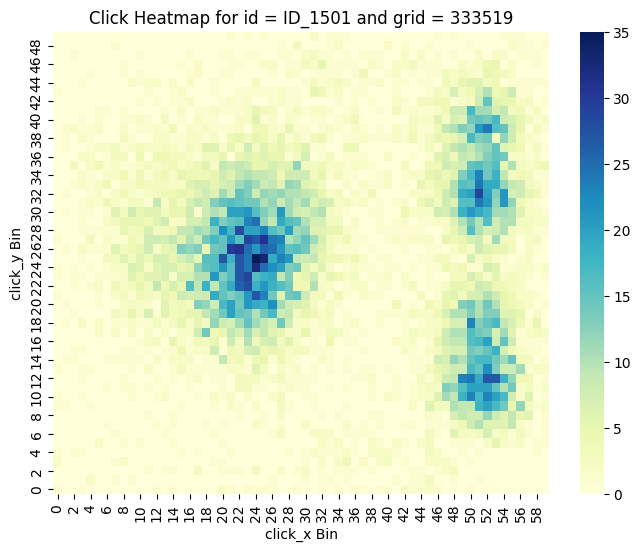

Total clicks for (grid_id, domain): (333519, ID_1501): 86364


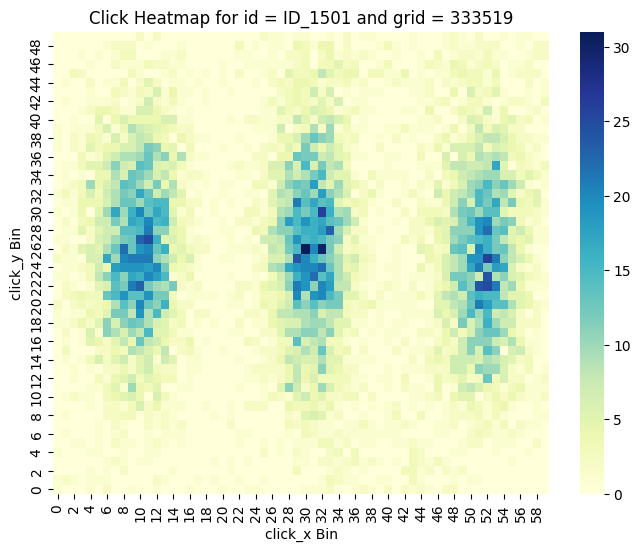

In [12]:
# selection of empirical distribution: pick most clicks and highest landing rate:

representative_heatmap = {}

for g_id in [333519, 333346]:
    filtered_data = data_metrics[data_metrics.grid_id == g_id]

    result = filtered_data[(filtered_data.landed_clicks / filtered_data.clicks) > 0.8]
    dom = result.sort_values(by='clicks', ascending=False).iloc[0].domain
    representative_heatmap[g_id] = dom
    
    data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                 (aggregated_clicks.domain == dom)]
    print(f'Total clicks for (grid_id, domain): (333519, {dom}): {data_obs.clicks_sum.sum()}')
    data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
    data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
    click_matrix = data_obs_enh.pivot("click_y_bin",
                                      "click_x_bin",
                                      "clicks_sum").fillna(0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(click_matrix, 
                cmap = "YlGnBu", 
                annot = False, 
                cbar = True, 
                fmt = "g")
    plt.title(f'Click Heatmap for id = {dom} and grid = {333519}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.show()

## 4b. Calculate the empirical distribution for the broken banners (i.e. represnetative broken banner)

Calculate the empirical distribution for the broken banners (i.e. $H_1$). To do this, we use the broken banners from the new dataset and sum all the distributions.

In [13]:
data_broken = {}
data_broken_proba = {}

In [14]:
for g_id in [333519, 333346]:
    agg_broken = aggregated_clicks_6p[(aggregated_clicks_6p.grid_id == g_id) & 
                      (aggregated_clicks_6p.domain.isin(cb_6p[g_id]))]
    
    data_broken[g_id] = agg_broken.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()
    
    total_clicks = agg_broken.groupby(['grid_id', 'domain'])['clicks_sum'].transform('sum')
    agg_broken['proba'] = agg_broken['clicks_sum'] / total_clicks
    
    data_broken_proba[g_id] = agg_broken.groupby(['click_x_bin','click_y_bin'
                            ]).sum('proba').reset_index()
    
    data_broken_proba[g_id]['proba1'] = data_broken_proba[g_id]['proba']/data_broken_proba[g_id].proba.sum()


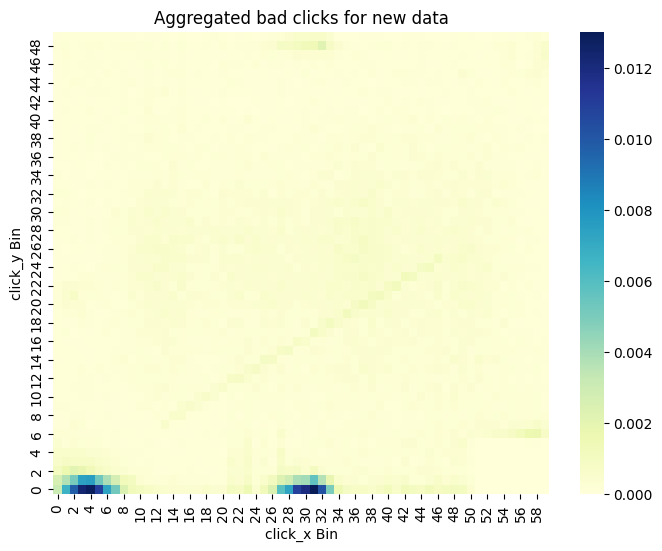

In [15]:
combined_agg_broken = data_broken_proba[333346].drop(columns = ['grid_id']).merge(data_broken_proba[333346].drop(columns = ['grid_id']), on = ['click_x_bin','click_y_bin'], how='outer').fillna(0)
combined_agg_broken['proba_comb'] = combined_agg_broken['proba_x']+combined_agg_broken['proba_y']
combined_agg_broken['proba_comb'] = combined_agg_broken['proba_comb']/combined_agg_broken.proba_comb.sum()

click_matrix = combined_agg_broken.pivot("click_y_bin",
                                  "click_x_bin",
                                  "proba_comb").fillna(0)
plt.figure(figsize=(8, 6))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")
plt.title(f'Aggregated bad clicks for new data')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
plt.show()

In [16]:
# data_bad = pd.DataFrame(list(product(range(0,60),range(0,50))), 
#                                           columns=['click_x_bin', 'click_y_bin'])
# data_bad['proba'] = 1/data_bad.shape[0]

data_bad_6p = pd.DataFrame(list(product(range(0,60),range(0,50))), 
                                          columns=['click_x_bin', 'click_y_bin'])
data_bad_6p['proba'] = 1/data_bad_6p.shape[0]

## 4c. Run gridsearch for LRT on old data:

### Defining functions

In [17]:
representative_heatmap

{333519: 'ID_1501', 333346: 'ID_1501'}

In [18]:
data_bad_6p

,click_x_bin,click_y_bin,proba
0,0,0,0.000333
1,0,1,0.000333
2,0,2,0.000333
3,0,3,0.000333
4,0,4,0.000333
...,...,...,...
2995,59,45,0.000333
2996,59,46,0.000333
2997,59,47,0.000333
2998,59,48,0.000333


In [19]:
######################## CREATING FUNCTION ########################
# representative_heatmap -> numerator
# data_bad_6p -> denominator
def LRT(aggregated_clicks, representative_heatmap, domains_by_grid_id, cb, data_bad_6p):
    start_time = time.time()
    # avoid dividing by 0:
    eps = 1e-20

    outputs = {333519: [], 333346: []}
    labels = {333519: [], 333346: []}
    domains = {333519: [], 333346: []}

    for g_id in [333519, 333346]: 
        data = pd.DataFrame(list(product(range(0,60),range(0,50))), 
                                    columns=['click_x_bin', 'click_y_bin'])

        # representative probabilities:
        data_obs_rep = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                            (aggregated_clicks.domain == representative_heatmap[g_id])]

        # merge enhanced observed heatmap with empirical distribution
        # in order to get empircal probabilities for bins:
        data_obs_rep = data_obs_rep.merge(data, 
                                        on=['click_x_bin','click_y_bin'], 
                                        how='right').fillna(0)

        data_obs_rep['proba'] = data_obs_rep.clicks_sum/data_obs_rep.clicks_sum.sum()

        data = data.merge(data_obs_rep[['click_x_bin','click_y_bin','proba']], 
                            on = ['click_x_bin','click_y_bin'], 
                            how='left' )

        data = data.fillna(0)


        # run over domains, dom for given grid_id = g_id:
        for dom in domains_by_grid_id[domains_by_grid_id.grid_id == g_id]['domain'].iloc[0]:

            # data_obs = "observed" heatmap for current domain_id = dom
            data_obs_1 = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                            (aggregated_clicks.domain == dom)]
            
            data_obs_1['clicks_sum'] = 1000*data_obs_1['clicks_sum']/data_obs_1['clicks_sum'].sum()
            data_obs = data_obs_1[['click_x_bin','click_y_bin','clicks_sum']].merge(data, 
                                            on=['click_x_bin','click_y_bin'], 
                                            how='right').fillna(0)
            
            from_obs = (np.log(data_obs['proba']+eps)*data_obs['clicks_sum']).sum()
            
            ####################
            # "lrt" method:

            data_obs_bad = data_obs_1[['click_x_bin','click_y_bin','clicks_sum']].merge(data_bad_6p, 
                                            on=['click_x_bin','click_y_bin'], 
                                            how='right').fillna(0)

            from_obs_bad = (np.log(data_obs_bad['proba']+eps)*data_obs_bad['clicks_sum']).sum()

            loglrt = from_obs - from_obs_bad

            
            outputs[g_id].append(loglrt)
            domains[g_id].append(dom)
            if dom in cb[g_id]: # broken
                labels[g_id].append(1)
            else: # working
                labels[g_id].append(0)

    end_time = time.time()
    nb_banners = len(domains_by_grid_id.iloc[0]['domain']) + len(domains_by_grid_id.iloc[1]['domain'])

    return (end_time - start_time) / nb_banners, outputs, labels, domains

In [20]:
def generate_preds(outputs, min, max):
    all_outputs = np.array(outputs[333346] + outputs[333519])
    preds = {}
    for g_id in [333346, 333519]:
        neg_outputs = np.negative(outputs[g_id])
        preds_g_id = (neg_outputs - min)/(max - min)
        preds_g_id = [1 if preds_g_id[i] > 1 else preds_g_id[i] for i in range(len(preds_g_id))]
        preds_g_id = [0 if preds_g_id[i] < 0 else preds_g_id[i] for i in range(len(preds_g_id))]
        preds[g_id] = preds_g_id
    return preds

In [21]:
def combine_all_outputs(output_list):
    return np.array(output_list[333346] + output_list[333519])

In [22]:
# def generate_all_preds(outputs, min, max):
#     all_outputs = np.array(outputs[333346] + outputs[333519])
#     neg_outputs = np.negative(all_outputs)
#     all_preds = (neg_outputs - min)/(max - min)
#     # all_preds = (neg_outputs - min(neg_outputs))/(max(neg_outputs) - min(neg_outputs))
#     all_preds = [1 if all_preds[i] > 1 else all_preds[i] for i in range(len(all_preds))]
#     all_preds = [0 if all_preds[i] < 0 else all_preds[i] for i in range(len(all_preds))]
#     return all_preds

In [23]:
def plot_heatmaps(heatmap_list):
    for dom in heatmap_list:
        for g_id in [333346]:
            filtered_data = data_metrics[data_metrics.grid_id == g_id]

            data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                        (aggregated_clicks.domain == dom)]
            print(f'Total clicks for (grid_id, domain): ({g_id}, {dom}): {data_obs.clicks_sum.sum()}')
            # data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
            # data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
            click_matrix = data_obs.pivot("click_y_bin",
                                            "click_x_bin",
                                            "clicks_sum").fillna(0)
            plt.figure(figsize=(8, 6))
            sns.heatmap(click_matrix, 
                        cmap = "YlGnBu", 
                        annot = False, 
                        cbar = True, 
                        fmt = "g")
            plt.title(f'Click Heatmap for id = {dom} and grid = {333519}')
            plt.xlabel('click_x Bin')
            plt.ylabel('click_y Bin')
            plt.gca().invert_yaxis() 
            plt.show()

In [24]:
def plot_roc_curve(all_labels, all_preds):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

    # Calculate AUC score
    auc = roc_auc_score(all_labels, all_preds)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return auc

In [25]:
def calculate_all_f1(all_labels, all_preds):
    threshs = np.linspace(1,0.01,100)
    best_f1 = 0
    best_thresh = 0
    all_f1 = []
    for thresh in threshs:
        all_preds_cut_off = [1 if all_preds[i] > thresh else 0 for i in range(len(all_preds))]
        f1 = f1_score(all_labels, all_preds_cut_off, average='macro')
        
        if best_f1 < f1:
            best_f1 = f1
            best_thresh = thresh
        all_f1.append(f1)
        # print(f1)
    return all_f1, best_f1, best_thresh

In [26]:
def identify_misclassified_banners(domains, preds, labels, thresh):
    fn = {}
    fp = {}
    for g_id in [333346, 333519]:
        fn_g_id = []
        fp_g_id = []
        domains_g_id = domains[g_id]
        for ind in range(len(domains[g_id])):
            preds_rounded = [0 if preds[g_id][i] < thresh else 1 for i in range(len(preds[g_id]))] 
            if preds_rounded[ind] == 0 and labels[g_id][ind] == 1: # False negative
                fn_g_id.append(domains_g_id[ind])
            elif preds_rounded[ind] == 1 and labels[g_id][ind] == 0: # False positive
                fp_g_id.append(domains_g_id[ind])
        fn[g_id] = fn_g_id
        fp[g_id] = fp_g_id
    return fn, fp

### Code execution

In [27]:
time_per_banner_old, outputs_old, labels_old, domains_old = LRT(aggregated_clicks, representative_heatmap, domains_by_grid_id, cb, data_bad_6p)

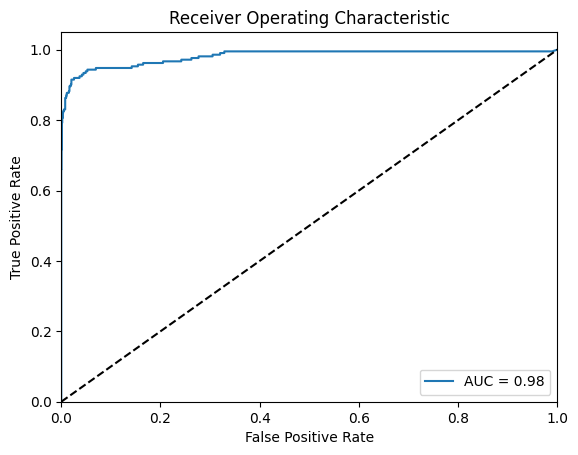

Time per banner:  0.05903197614292292
Best f1 is 0.94 at threshold 0.55
Confusion matrix at best threshold: 
[[1508   13]
 [  29  183]]
AUC:  0.9811227717613784


In [28]:
preds_old = generate_preds(outputs_old, -1000, 1000)
all_labels_old = combine_all_outputs(labels_old)
all_preds_old = combine_all_outputs(preds_old)
all_outputs_old = combine_all_outputs(outputs_old)
all_f1_old, best_f1_old, best_thresh_old = calculate_all_f1(all_labels_old, all_preds_old)
all_preds_rounded_old = [1 if all_preds_old[i] > best_thresh_old else 0 for i in range(len(all_preds_old))]
fn_old, fp_old = identify_misclassified_banners(domains_old, preds_old, labels_old, best_thresh_old)
auc_old = plot_roc_curve(all_labels_old, all_preds_old)

print("Time per banner: ", time_per_banner_old) # time per domain
print(f"Best f1 is {round(best_f1_old, 2)} at threshold {round(best_thresh_old, 2)}")
print("Confusion matrix at best threshold: ")
print(confusion_matrix(all_labels_old, all_preds_rounded_old))
print("AUC: ", auc_old)

In [29]:
old = {"preds": preds_old, "outputs": outputs_old, "labels": labels_old, "domains": domains_old, "time_per_banner": time_per_banner_old}

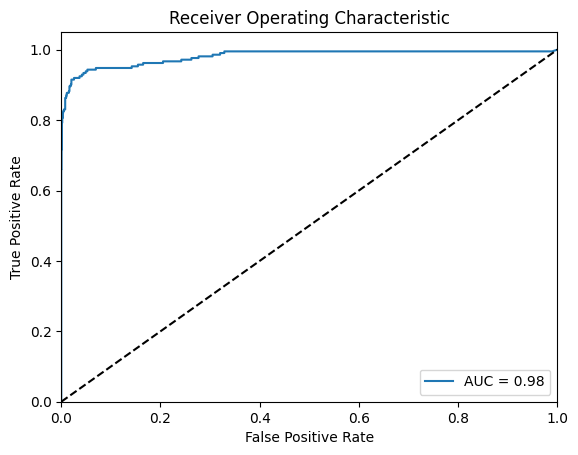

0.9811227717613784

In [30]:
plot_roc_curve(all_labels_old, all_preds_old)

(array([ 88., 165., 249., 289., 288., 210., 119.,  56.,  34.,  27.,  12.,
         14.,   9.,   9.,   9.,  12.,  13.,  13.,  11., 106.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

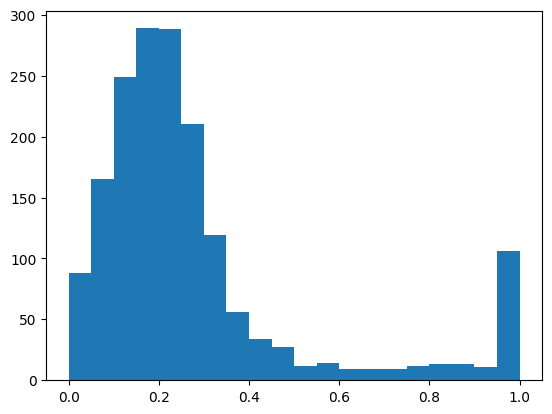

In [31]:
plt.hist(all_preds_old, bins = 20)

(array([  1.,   1.,   7.,   2.,   0.,   0.,   2.,   5.,  19.,  30.,  28.,
         39.,  31.,  28.,  63., 240., 759., 452.,  25.,   1.]),
 array([-3986.31126623, -3710.23728313, -3434.16330003, -3158.08931693,
        -2882.01533383, -2605.94135073, -2329.86736762, -2053.79338452,
        -1777.71940142, -1501.64541832, -1225.57143522,  -949.49745212,
         -673.42346902,  -397.34948592,  -121.27550282,   154.79848028,
          430.87246339,   706.94644649,   983.02042959,  1259.09441269,
         1535.16839579]),
 <BarContainer object of 20 artists>)

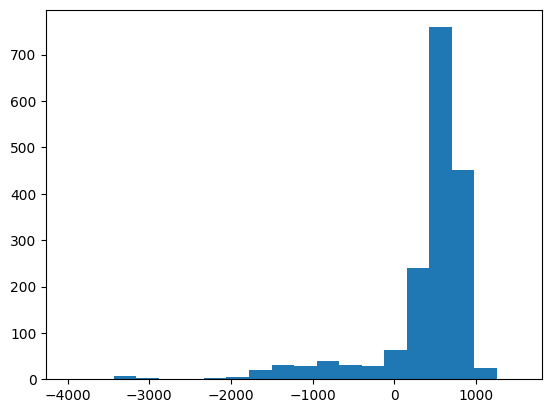

In [32]:
plt.hist(all_outputs_old, bins = 20)

Total clicks for (grid_id, domain): (333346, ID_1082): 1972


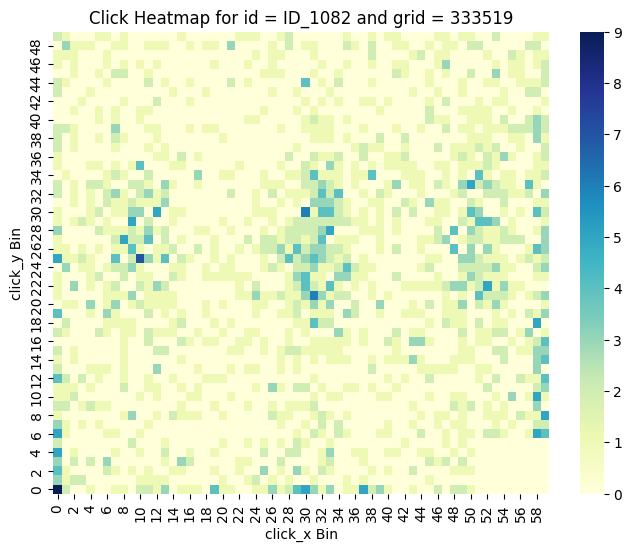

Total clicks for (grid_id, domain): (333346, ID_1612): 313


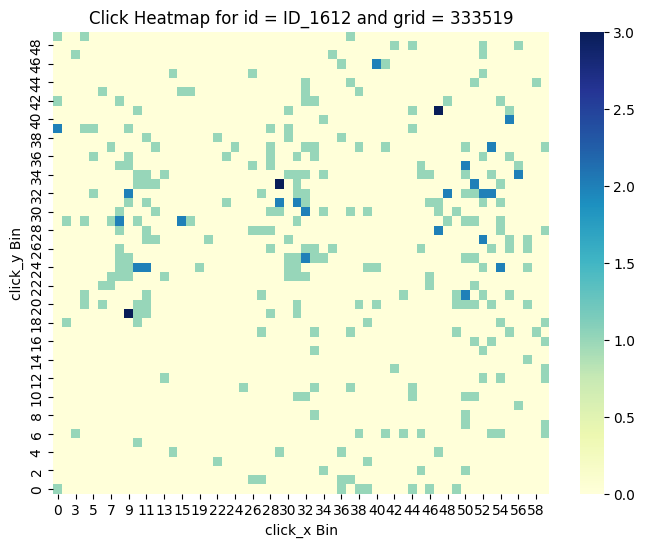

Total clicks for (grid_id, domain): (333346, ID_3007): 2152


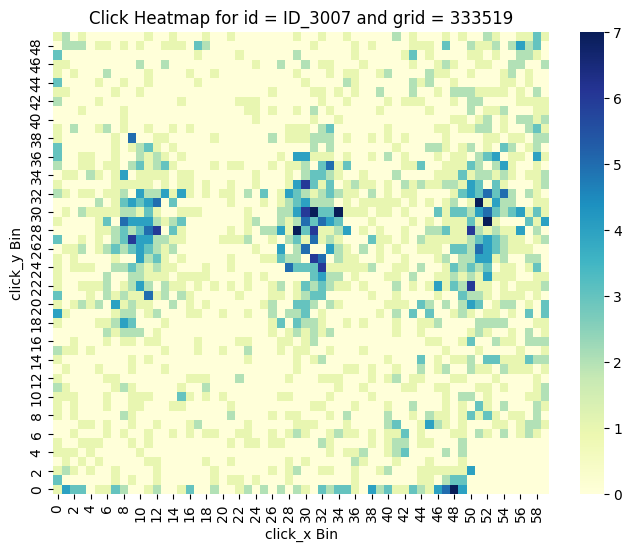

Total clicks for (grid_id, domain): (333346, ID_336): 244


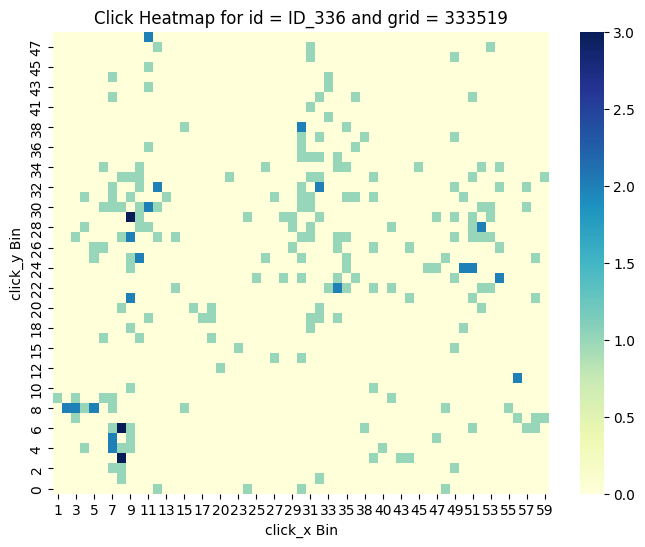

Total clicks for (grid_id, domain): (333346, ID_3414): 516


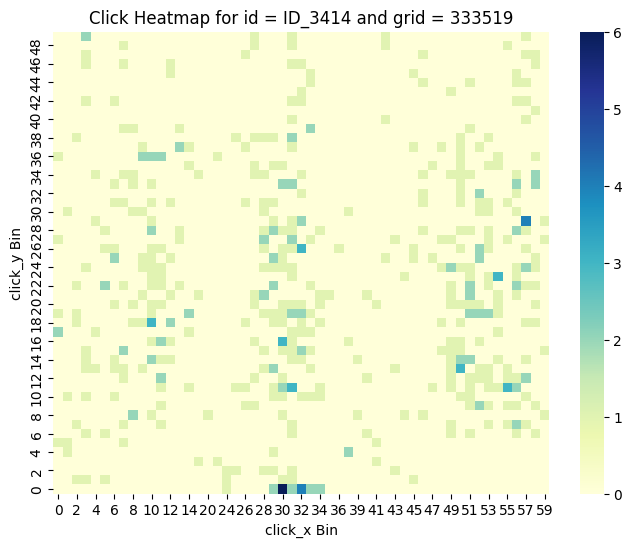

Total clicks for (grid_id, domain): (333346, ID_650): 761


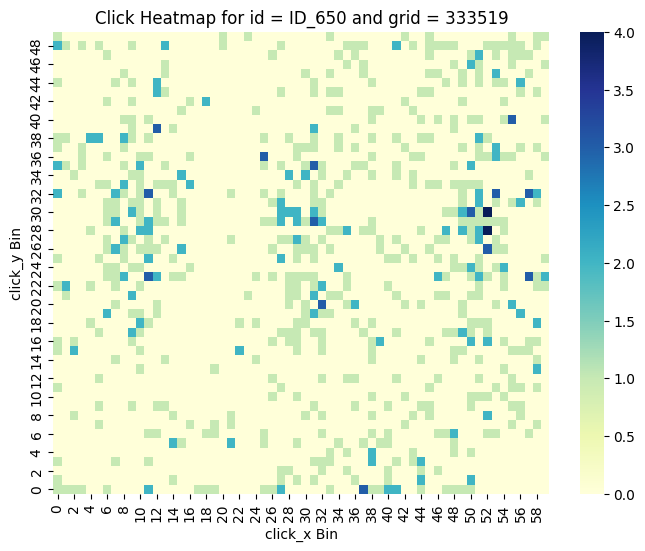

In [33]:
plot_heatmaps(fp_old[333346])

# 5. LRT - New data:

## 5a. Representative working

Total clicks for (grid_id, domain): (333519, ID_3516): 482667


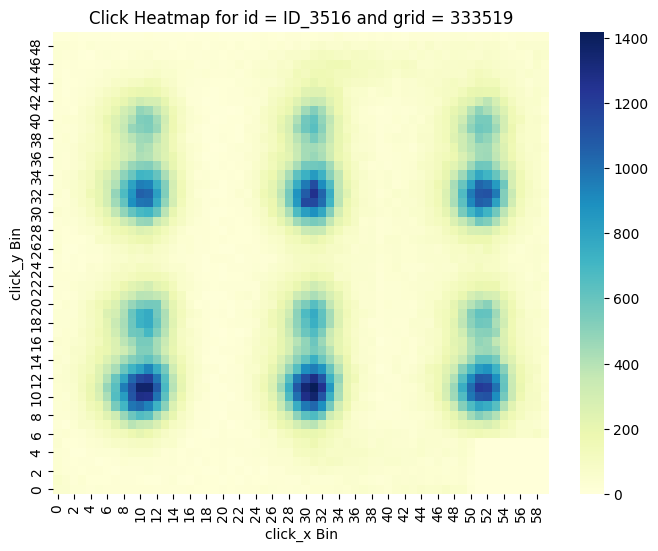

Total clicks for (grid_id, domain): (333346, ID_3709): 29316


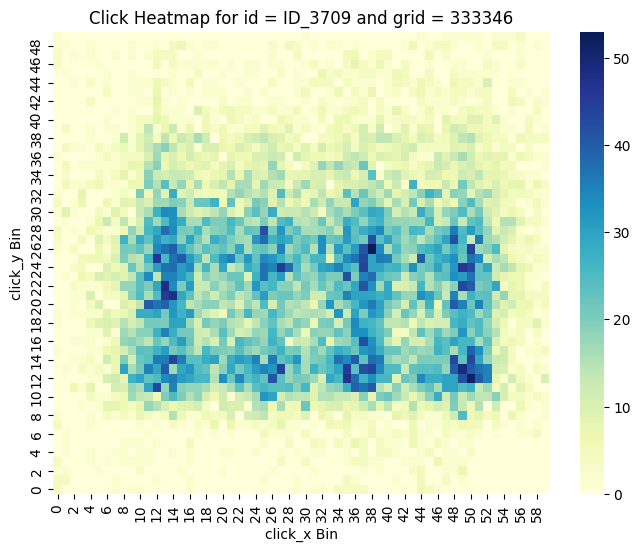

In [34]:
representative_heatmap_6p = {}

for g_id in [333519, 333346]:
    filtered_data = data_metrics_6p[data_metrics_6p.grid_id == g_id]

    result    = filtered_data[(filtered_data.landed_clicks / filtered_data.clicks) > 0.8]
    uniq_doms = result.domain.unique()
    f1 = data_heatmap_6p[(data_heatmap_6p.grid_id==g_id)]
    dom_sorted = f1[f1.domain.isin(uniq_doms)].groupby(['domain']).sum('clicks').sort_values(by='clicks', 
                                                                                             ascending=False)
    dom = dom_sorted.reset_index().iloc[0].domain
    representative_heatmap_6p[g_id] = dom
    
    data_obs = aggregated_clicks_6p[(aggregated_clicks_6p.grid_id == g_id) &
                                 (aggregated_clicks_6p.domain == dom)]
    print(f'Total clicks for (grid_id, domain): ({g_id}, {dom}): {data_obs.clicks_sum.sum()}')
    data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
    #data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
    click_matrix = data_obs.pivot("click_y_bin",
                                      "click_x_bin",
                                      "clicks_sum").fillna(0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(click_matrix, 
                cmap = "YlGnBu", 
                annot = False, 
                cbar = True, 
                fmt = "g")
    plt.title(f'Click Heatmap for id = {dom} and grid = {g_id}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.show()

In [35]:
data_heatmap_6p[(data_heatmap_6p.grid_id==333346)].groupby(['domain']).sum('clicks').sort_values(by='clicks', 
                                                                                             ascending=False).head(5)

,Unnamed: 0,grid_id,click_x,click_y,display_height,display_width,clicks
domain,,,,,,,
ID_3516,176085547398,16285952176,7648508,6109790,12214000,14656800,208944
ID_1220,169149476860,13909861888,6364339,5397037,10432000,12518400,109542
ID_762,115841530327,11152090430,5175136,4181641,8363750,10036500,66326
ID_2883,83035543672,7281943370,3416916,3093539,5461250,6553500,35724
ID_2387,82165179182,6804258552,3194504,2803468,5103000,6123600,31977


Total clicks for (grid_id, domain): (333519, ID_3516): 262245


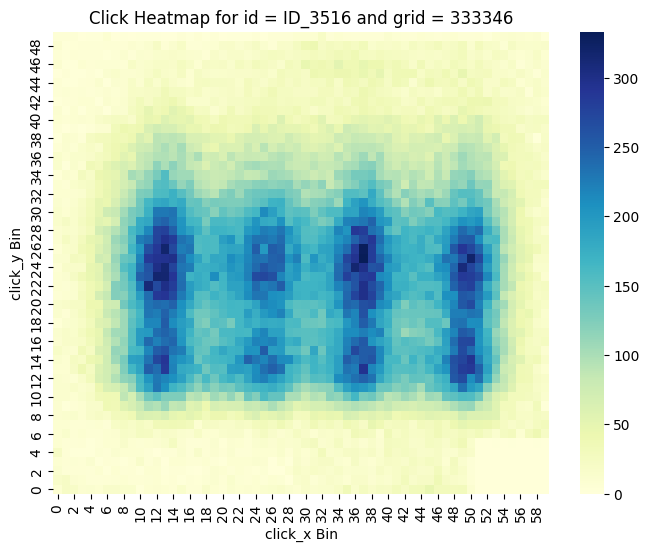

In [36]:
dom = 'ID_3516'
representative_heatmap_6p[333346] = dom
    
data_obs = aggregated_clicks_6p[(aggregated_clicks_6p.grid_id == g_id) &
                             (aggregated_clicks_6p.domain == dom)]
print(f'Total clicks for (grid_id, domain): (333519, {dom}): {data_obs.clicks_sum.sum()}')
data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
# data_obs_enh = enhance_data(data_obs, 'proba', 200000, 0)
click_matrix = data_obs.pivot("click_y_bin",
                                  "click_x_bin",
                                  "clicks_sum").fillna(0)
plt.figure(figsize=(8, 6))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")
plt.title(f'Click Heatmap for id = {dom} and grid = {333346}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
plt.show()

## 5b. Representative broken (using bad data from old data)

In [37]:
for g_id in [333519, 333346]:
    agg_broken = aggregated_clicks[(aggregated_clicks.grid_id == g_id) & 
                      (aggregated_clicks.domain.isin(cb[g_id]))]
    
    data_broken[g_id] = agg_broken.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()
    
    total_clicks = agg_broken.groupby(['grid_id', 'domain'])['clicks_sum'].transform('sum')
    agg_broken['proba'] = agg_broken['clicks_sum'] / total_clicks
    
    data_broken_proba[g_id] = agg_broken.groupby(['click_x_bin','click_y_bin'
                            ]).sum('proba').reset_index()
    
    data_broken_proba[g_id]['proba1'] = data_broken_proba[g_id]['proba']/data_broken_proba[g_id].proba.sum()
    

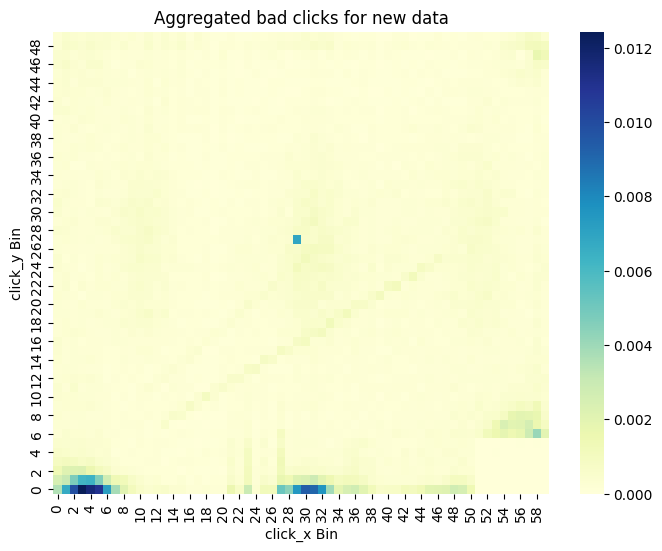

In [38]:
combined_agg_broken = data_broken_proba[333346].drop(columns = ['grid_id']).merge(data_broken_proba[333346].drop(columns = ['grid_id']), on = ['click_x_bin','click_y_bin'], how='outer').fillna(0)
combined_agg_broken['proba_comb'] = combined_agg_broken['proba_x']+combined_agg_broken['proba_y']
combined_agg_broken['proba_comb'] = combined_agg_broken['proba_comb']/combined_agg_broken.proba_comb.sum()

click_matrix = combined_agg_broken.pivot("click_y_bin",
                                  "click_x_bin",
                                  "proba_comb").fillna(0)
plt.figure(figsize=(8, 6))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")
plt.title(f'Aggregated bad clicks for new data')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
plt.show()

In [39]:
data_bad = pd.DataFrame(list(product(range(0,60),range(0,50))), 
                                          columns=['click_x_bin', 'click_y_bin'])
data_bad['proba'] = 1/data_bad.shape[0]

## 5c. Grid search for new data

In [40]:
domains_by_grid_id_6p

,grid_id,domain
0,333346,"[ID_1003, ID_1007, ID_1013, ID_1022, ID_1030, ..."
1,333519,"[ID_10, ID_1000, ID_1001, ID_1007, ID_1008, ID..."


In [41]:
time_per_banner_new, outputs_new, labels_new, domains_new = LRT(aggregated_clicks_6p, representative_heatmap_6p, domains_by_grid_id_6p, cb_6p, data_bad)

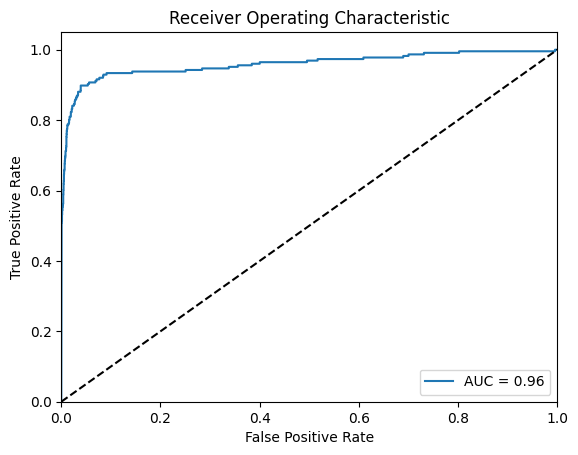

Time per banner:  0.10251886026300613
Best f1 is 0.9 at threshold 0.56
Confusion matrix at best threshold: 
[[2769   35]
 [  48  178]]
AUC: 0.9585674068650348


In [48]:
preds_new = generate_preds(outputs_new, -1000, 1000)
all_labels_new = combine_all_outputs(labels_new)
all_preds_new = combine_all_outputs(preds_new)
all_outputs_new = combine_all_outputs(outputs_new)
all_f1_new, best_f1_new, best_thresh_new = calculate_all_f1(all_labels_new, all_preds_new)
all_preds_rounded_new = [1 if all_preds_new[i] > best_thresh_new else 0 for i in range(len(all_preds_new))]
fn_new, fp_new = identify_misclassified_banners(domains_new, preds_new, labels_new, best_thresh_new)
auc_new = plot_roc_curve(all_labels_new, all_preds_new)

print("Time per banner: ", time_per_banner_new) # time per domain
print(f"Best f1 is {round(best_f1_new, 2)} at threshold {round(best_thresh_new, 2)}")
print("Confusion matrix at best threshold: ")
print(confusion_matrix(all_labels_new, all_preds_rounded_new))
print("AUC:", auc_new)

In [43]:
new = {"preds": preds_new, "outputs": outputs_new, "labels": labels_new, "domains": domains_new, "time_per_banner": time_per_banner_new}

(array([  4.,  17.,  84., 272., 655., 771., 531., 283., 102.,  62.,  32.,
         19.,  18.,  24.,  23.,  25.,  12.,  12.,   6.,  78.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

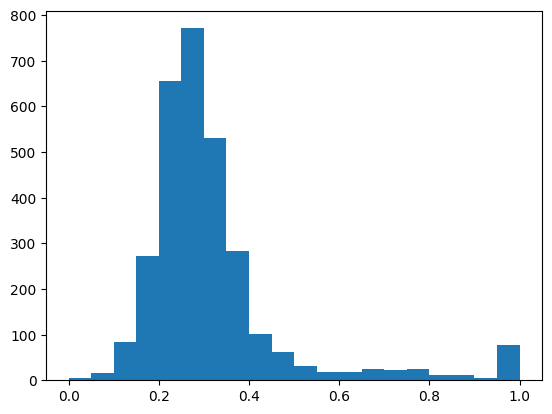

In [44]:
plt.hist(all_preds_new, bins = 20)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 4.000e+00, 7.000e+00, 9.000e+00, 1.400e+01, 1.700e+01,
        1.600e+01, 2.300e+01, 5.400e+01, 6.200e+01, 1.440e+02, 1.146e+03,
        1.466e+03, 6.400e+01]),
 array([-4797.73209801, -4507.08398364, -4216.43586928, -3925.78775491,
        -3635.13964055, -3344.49152618, -3053.84341182, -2763.19529745,
        -2472.54718309, -2181.89906872, -1891.25095436, -1600.60283999,
        -1309.95472563, -1019.30661126,  -728.6584969 ,  -438.01038254,
         -147.36226817,   143.28584619,   433.93396056,   724.58207492,
         1015.23018929]),
 <BarContainer object of 20 artists>)

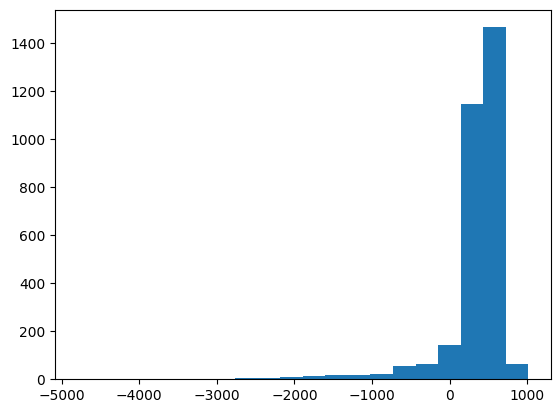

In [45]:
plt.hist(all_outputs_new, bins = 20)

# 6. Save outputs

In [46]:
import pickle 

results = {"new": new, "old": old}

with open('Stat_approach_output/test_2.pkl', 'wb') as f:
    pickle.dump(results, f)
        

In [47]:
with open('Stat_approach_output/test_2.pkl', 'rb') as f:
    check_results = pickle.load(f)